# Análise de desempenho - `coordinator` e `process`

## Importação das bibliotecas

In [1]:
from os import makedirs
import subprocess

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from log_validator import validate

makedirs("./data", exist_ok=True)

## Definição dos Testes de Funcionamento

In [2]:
TESTS = {
    0: {
        "n": [2],
        "k": 2,
        "r": 10
    },
    1: {
        "n": [2, 4, 8, 16, 32],
        "k": 2,
        "r": 10
    },
    2: {
        "n": [2, 4, 8, 16, 32, 64],
        "k": 1,
        "r": 5
    },
    3: {
        "n": [2, 4, 8, 16, 32, 64],
        "k": 0,
        "r": 3
    },
}

## Execução dos programas `process` e `coordinator`<br>para diferentes parâmetros de $N$, $K$ e $R$

In [3]:
for test_number, test_params in TESTS.items():
    print(f"> Running Test #{test_number}")
    coordinator_command = subprocess.Popen(
        [
            "./03_Coordinator/target/release/coordinator",
            "-l",
            f"coordenador_teste_{test_number}"
        ],
        stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE
    )
    for n in tqdm(test_params["n"]):
        n_command = subprocess.getoutput(
            f"./04_Process/target/release/process -n {n} -k {test_params['k']} -r {test_params['r']} -l resultados_teste_{test_number}_n_{n}"
        )
    coordinator_command.kill()

> Running Test #0


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


> Running Test #1


100%|██████████| 5/5 [20:45<00:00, 249.17s/it]


> Running Test #2


100%|██████████| 6/6 [10:32<00:00, 105.41s/it]


> Running Test #3


100%|██████████| 6/6 [00:00<00:00,  7.90it/s]


## Criação de DataFrame para os resultados

In [3]:
results_df = pd.DataFrame(columns=[
    "test_number",
    "n",
    "k",
    "r",
    "elapsed"
])

## Validação dos logs

In [54]:
from log_validator import validate

for test_number in TESTS.keys():
    print(
        "Test #",
        test_number,
        " - ",
        sep="",
        end=""
    )
    validate(f"./log/coordenador_teste_{test_number}.log")

Test #0 - Log file was successfully validated
Test #1 - Log file was successfully validated
Test #2 - Log file was successfully validated
Test #3 - Log file was successfully validated


## Análise dos resultados

In [53]:
for test_number, test_params in TESTS.items():
    for n in test_params["n"]:
        with open(f"./log/resultados_teste_{test_number}_n_{n}.txt") as file:
            all_lines = file.readlines()
            first_line = float(all_lines[0].split("-")[0].strip())
            last_line = float(all_lines[-1].split("-")[0].strip())
            results_df = pd.concat(
                [
                    results_df,
                    pd.DataFrame(
                        [(
                            test_number,
                            n,
                            test_params["k"],
                            test_params["r"],
                            last_line-first_line
                        )],
                        columns=[
                            "test_number",
                            "n",
                            "k",
                            "r",
                            "elapsed"
                        ]
                    )
                ],
                ignore_index=True
            )

results_df.to_csv("./data/benchmark.csv", sep=";", index=False)

## Gráfico com resultados

In [6]:
results_df

,test_number,n,k,r,elapsed
0,0,2,2,10,38.037642
1,1,2,2,10,38.039901
2,1,4,2,10,78.075278
3,1,8,2,10,158.19236
4,1,16,2,10,318.304348
5,1,32,2,10,643.080039
6,2,2,1,5,9.196387
7,2,4,1,5,19.037196
8,2,8,1,5,39.072292
9,2,16,1,5,79.14286


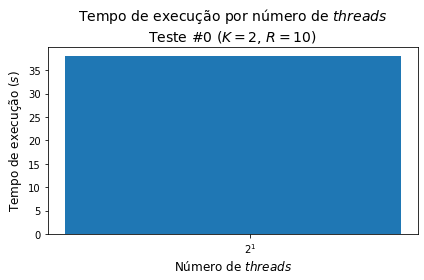

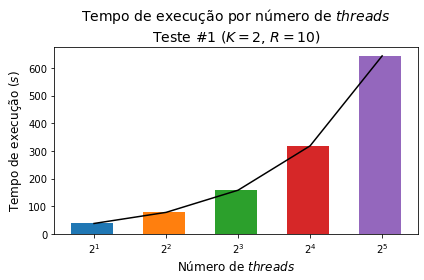

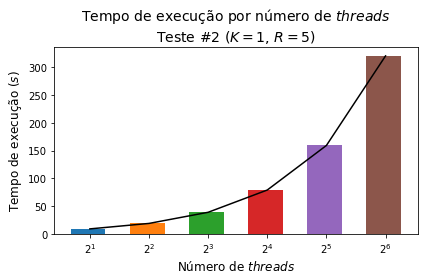

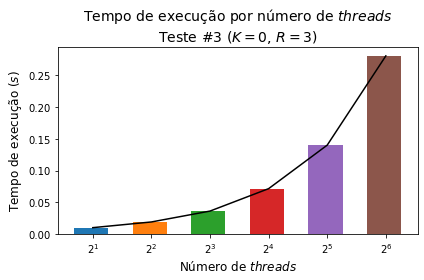

In [50]:
for test_number, test_params in TESTS.items():
    fig, ax = plt.subplots()
    _ = results_df.loc[
        results_df["test_number"] == test_number
    ][["n", "elapsed"]]

    for i, n, elapsed in _.itertuples():
        ax.bar(
            x = n,
            height = elapsed,
            width = 0.8*n/2,
            align="center"
        )
    ax.plot(
        _["n"],
        _["elapsed"],
        color = "black"
    )
    ax.set_title(
        "{}\n{}".format(
            "Tempo de execução por número de $threads$",
            f"Teste #{test_number} ($K = {test_params['k']}$, $R = {test_params['r']}$)"
        ),
        fontsize=14
    )
    ax.set_xscale("log", base=2)
    ax.set_xticks([2**i for i in range(1, len(test_params["n"])+1)])
    ax.set_xlabel("Número de $threads$", fontsize=12)
    ax.set_ylabel("Tempo de execução ($s$)", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"./data/test_plot_{test_number}.png", format="png", dpi=300);
    plt.savefig(f"./data/test_plot_{test_number}.pdf", format="pdf", dpi=300);